In [8]:
import pandas as pd

# Load the dataset directly from GitHub
links_url = 'https://raw.githubusercontent.com/a-lindsay21/MovieLens_Recommendation_System/refs/heads/main/data/links.csv'
movies_url = 'https://raw.githubusercontent.com/a-lindsay21/MovieLens_Recommendation_System/refs/heads/main/data/movies.csv'
ratings_url = 'https://raw.githubusercontent.com/a-lindsay21/MovieLens_Recommendation_System/refs/heads/main/data/ratings.csv'
tags_url = 'https://raw.githubusercontent.com/a-lindsay21/MovieLens_Recommendation_System/refs/heads/main/data/tags.csv'

links = pd.read_csv(links_url)
movies = pd.read_csv(movies_url)
ratings = pd.read_csv(ratings_url)
tags = pd.read_csv(tags_url)

# Explore the ratings dataset
print("Ratings Dataset:")
print(ratings.head())
print(ratings.info())

# Explore the movies dataset
print("\nMovies Dataset:")
print(movies.head())
print(movies.info())

print("\nTags Dataset:")
print(tags.head())
print(tags.info())


Ratings Dataset:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB
None

Movies Dataset:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                          

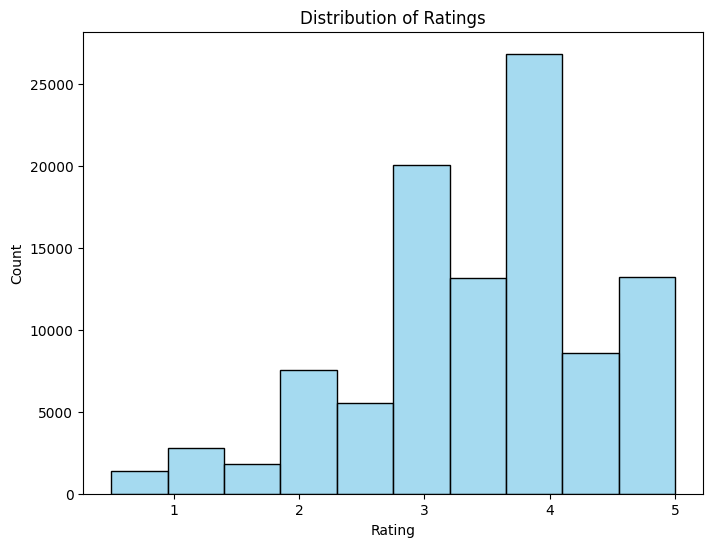

Top 10 most-rated movies:
 movieId
356     329
318     317
296     307
593     279
2571    278
260     251
480     238
110     237
589     224
527     220
dtype: int64

Top 10 most-active users:
 userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
dtype: int64


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of ratings
plt.figure(figsize=(8, 6))
sns.histplot(ratings['rating'], bins=10, kde=False, color='skyblue')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Top 10 most-rated movies
most_rated = ratings.groupby('movieId').size().sort_values(ascending=False).head(10)
print("Top 10 most-rated movies:\n", most_rated)

# Most active users (users who rated the most movies)
most_active_users = ratings.groupby('userId').size().sort_values(ascending=False).head(10)
print("\nTop 10 most-active users:\n", most_active_users)


In [10]:
# Count movies by genre
movies['genre_count'] = movies['genres'].apply(lambda x: len(x.split('|')))
print("Average number of genres per movie:", movies['genre_count'].mean())

# Most common genres
from collections import Counter
genres = movies['genres'].str.split('|').explode()
most_common_genres = Counter(genres).most_common(10)
print("Most common genres:\n", most_common_genres)

# Merge ratings and movies datasets for deeper analysis
ratings_movies = pd.merge(ratings, movies, on='movieId')
highest_rated_movies = ratings_movies.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)
print("\nTop 10 highest-rated movies:\n", highest_rated_movies)


Average number of genres per movie: 2.2668856497639087
Most common genres:
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596), ('Adventure', 1263), ('Crime', 1199), ('Sci-Fi', 980), ('Horror', 978), ('Fantasy', 779)]

Top 10 highest-rated movies:
 title
Gena the Crocodile (1969)                    5.0
True Stories (1986)                          5.0
Cosmic Scrat-tastrophe (2015)                5.0
Love and Pigeons (1985)                      5.0
Red Sorghum (Hong gao liang) (1987)          5.0
Thin Line Between Love and Hate, A (1996)    5.0
Lesson Faust (1994)                          5.0
Eva (2011)                                   5.0
Who Killed Chea Vichea? (2010)               5.0
Siam Sunset (1999)                           5.0
Name: rating, dtype: float64


In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# Create a pivot table: Users as rows, Movies as columns, Ratings as values
user_movie_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

# Fill NaN values with 0 (movies not rated by a user)
user_movie_matrix.fillna(0, inplace=True)

# Compute cosine similarity for movies
movie_similarity = cosine_similarity(user_movie_matrix.T)  # Transpose to compute item-based similarity
movie_similarity_df = pd.DataFrame(movie_similarity, index=user_movie_matrix.columns, columns=user_movie_matrix.columns)

# Function to recommend movies
def recommend_movies(movie_id, similarity_matrix, movies_df, top_n=10):
    # Get similar movies
    similar_movies = similarity_matrix[movie_id].sort_values(ascending=False).head(top_n + 1)  # +1 to exclude the movie itself
    # Map movie IDs to titles
    recommended_titles = movies_df[movies_df['movieId'].isin(similar_movies.index)]['title']
    return recommended_titles.iloc[1:].tolist()  # Skip the input movie itself

# Test the recommendation function
test_movie_id = 356  # Replace with any movieId from the most-rated list
recommended_movies = recommend_movies(test_movie_id, movie_similarity_df, movies)
print(f"Movies similar to {movies[movies['movieId'] == test_movie_id]['title'].values[0]}:")
print(recommended_movies)


Movies similar to Forrest Gump (1994):
['Apollo 13 (1995)', 'Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)', 'Forrest Gump (1994)', 'Jurassic Park (1993)', 'Mrs. Doubtfire (1993)', "Schindler's List (1993)", 'Terminator 2: Judgment Day (1991)', 'Silence of the Lambs, The (1991)', 'Matrix, The (1999)']


In [12]:
# Compute cosine similarity for users
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)

# Function to recommend movies based on similar users
def recommend_movies_user(user_id, similarity_matrix, user_movie_matrix, movies_df, top_n=10):
    # Get similar users
    similar_users = similarity_matrix[user_id].sort_values(ascending=False).head(top_n + 1)  # +1 to exclude the user itself
    # Aggregate ratings from similar users
    similar_users_ratings = user_movie_matrix.loc[similar_users.index].mean(axis=0)
    # Recommend movies the user hasn't seen
    recommended_movie_ids = similar_users_ratings[user_movie_matrix.loc[user_id] == 0].sort_values(ascending=False).head(top_n).index
    recommended_titles = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]['title']
    return recommended_titles.tolist()

# Test user-based recommendations
test_user_id = 414  # Replace with a top active user ID
recommended_user_movies = recommend_movies_user(test_user_id, user_similarity_df, user_movie_matrix, movies)
print(f"Movies recommended for user {test_user_id}:")
print(recommended_user_movies)


Movies recommended for user 414:
['Robin Hood: Men in Tights (1993)', 'Kingpin (1996)', 'Psycho (1960)', 'Day the Earth Stood Still, The (1951)', 'Shining, The (1980)', 'Halloween (1978)', 'One Hour Photo (2002)', 'Harry Potter and the Prisoner of Azkaban (2004)', "Ocean's Twelve (2004)", 'Borat: Cultural Learnings of America for Make Benefit Glorious Nation of Kazakhstan (2006)']


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF matrix for genres
tfidf = TfidfVectorizer(tokenizer=lambda x: x.split('|'))
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Compute cosine similarity for genres
genre_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to recommend movies based on genres
def recommend_movies_genre(movie_title, similarity_matrix, movies_df, top_n=10):
    movie_idx = movies_df[movies_df['title'] == movie_title].index[0]
    similar_movies = similarity_matrix[movie_idx].argsort()[::-1][1:top_n + 1]
    return movies_df.iloc[similar_movies]['title'].tolist()

# Test genre-based recommendations
recommended_genre_movies = recommend_movies_genre("Forrest Gump (1994)", genre_similarity, movies)
print(f"Movies similar to Forrest Gump (1994) based on genres:")
print(recommended_genre_movies)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Movies similar to Forrest Gump (1994) based on genres:
['Train of Life (Train de vie) (1998)', 'I Served the King of England (Obsluhoval jsem anglického krále) (2006)', 'Tiger and the Snow, The (La tigre e la neve) (2005)', 'Forrest Gump (1994)', 'Messenger, The (2009)', 'Atonement (2007)', "Captain Corelli's Mandolin (2001)", 'Year of Living Dangerously, The (1982)', 'Edge of Love, The (2008)', 'Hiroshima Mon Amour (1959)']


In [15]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Create a train-test split for evaluation
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=42)

# Create a user-movie matrix for training data
train_matrix = train_data.pivot(index='userId', columns='movieId', values='rating')
train_matrix.fillna(0, inplace=True)

# Create the similarity matrix for collaborative filtering
train_similarity = cosine_similarity(train_matrix.T)

# Map movieId to matrix indices
movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(train_matrix.columns)}
index_to_movie_id = {idx: movie_id for movie_id, idx in movie_id_to_index.items()}

def predict_rating(user_id, movie_id, similarity_matrix, user_movie_matrix, movie_id_to_index):
    # Check if movie_id exists in the mapping
    if movie_id in movie_id_to_index:
        movie_index = movie_id_to_index[movie_id]
        # Get similarity scores for the movie
        similar_movies = similarity_matrix[movie_index]
        user_ratings = user_movie_matrix.loc[user_id]
        weighted_ratings = similar_movies * user_ratings
        predicted_rating = weighted_ratings.sum() / np.abs(similar_movies).sum()
        return predicted_rating
    else:
        return np.nan  # Movie not in training set

# Generate predictions for the test set
test_data['predicted_rating'] = test_data.apply(
    lambda row: predict_rating(row['userId'], row['movieId'], train_similarity, train_matrix, movie_id_to_index), axis=1
)

# Drop NaN predictions
test_data = test_data.dropna(subset=['predicted_rating'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data['rating'], test_data['predicted_rating']))
print(f"RMSE for Collaborative Filtering: {rmse}")



RMSE for Collaborative Filtering: 3.376997074200516


In [16]:
def precision_at_k(recommendations, relevant_items, k=10):
    # Get the top K recommendations
    recommended_top_k = recommendations[:k]
    # Calculate Precision@K
    precision = len(set(recommended_top_k) & set(relevant_items)) / k
    return precision

# Example: Evaluate Precision@K for a single user
user_id = 414  # Replace with an actual user ID from your dataset

# Get relevant items for the user (movies they rated 4 or above)
relevant_items = ratings[(ratings['userId'] == user_id) & (ratings['rating'] >= 4)]['movieId'].tolist()

# Get top 10 recommendations for the user from the content-based model
recommended_movies = recommend_movies_user(user_id, user_similarity_df, train_matrix, movies, top_n=10)

# Calculate Precision@K
precision = precision_at_k(recommended_movies, relevant_items, k=10)
print(f"Precision@10 for User {user_id}: {precision}")


Precision@10 for User 414: 0.0


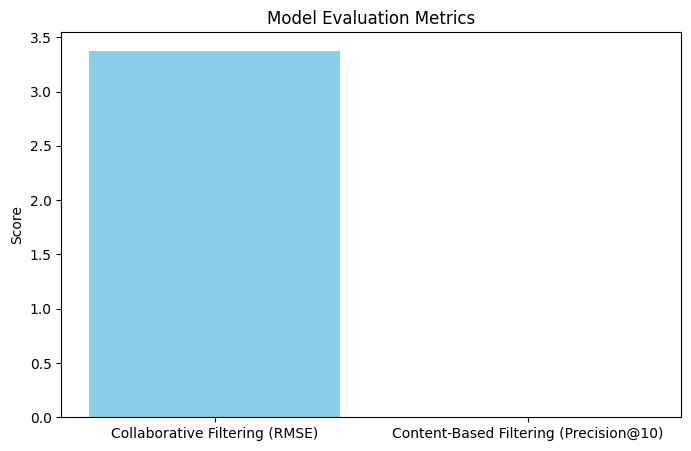

In [17]:
import matplotlib.pyplot as plt

# Example results
results = {
    'Collaborative Filtering (RMSE)': rmse,
    'Content-Based Filtering (Precision@10)': precision
}

# Plot results
plt.figure(figsize=(8, 5))
plt.bar(results.keys(), results.values(), color=['skyblue', 'lightgreen'])
plt.title('Model Evaluation Metrics')
plt.ylabel('Score')
plt.show()


In [19]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357269 sha256=6251eef3bb8d907d4c593a454e45c7cda53501c52769f8f1264675f1aea65cf3
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [20]:
from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.accuracy import rmse

# Load data for Surprise library
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

# Train-test split
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# Build and train the SVD model
svd_model = SVD()
svd_model.fit(trainset)

# Predict on test set and evaluate RMSE
predictions = svd_model.test(testset)
print("RMSE for SVD Collaborative Filtering:", rmse(predictions))


RMSE: 0.8818
RMSE for SVD Collaborative Filtering: 0.8817917476468825


In [21]:
# Create user profiles based on their rated movies
user_profiles = ratings.merge(movies, on='movieId')
user_genres = user_profiles.groupby('userId')['genres'].apply(lambda x: ' '.join(x)).reset_index()

# Use TF-IDF for personalized recommendations
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=lambda x: x.split('|'))
user_genre_matrix = tfidf.fit_transform(user_genres['genres'])

# Compute cosine similarity for a specific user
user_id = 414  # Example user
user_index = user_genres[user_genres['userId'] == user_id].index[0]
similar_users = cosine_similarity(user_genre_matrix[user_index], user_genre_matrix).flatten()

# Recommend movies based on similar users
top_similar_users = user_genres.iloc[similar_users.argsort()[::-1][1:11]]['userId']
print("Users similar to User 414:", top_similar_users.tolist())


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Users similar to User 414: [599, 480, 68, 182, 232, 489, 448, 590, 560, 64]


In [22]:
def hybrid_recommendation(user_id, svd_model, user_similarity_df, movies_df, top_n=10):
    # Collaborative Filtering (SVD) Predictions
    collaborative_predictions = []
    for movie_id in movies_df['movieId']:
        try:
            collaborative_predictions.append((movie_id, svd_model.predict(user_id, movie_id).est))
        except:
            collaborative_predictions.append((movie_id, 0))  # Default to 0 if prediction fails

    # Content-Based Filtering (Genres)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False).head(10).index
    genre_recommendations = ratings[ratings['userId'].isin(similar_users)]['movieId'].value_counts().index[:top_n]

    # Combine Scores
    hybrid_scores = {}
    for movie_id, score in collaborative_predictions:
        if movie_id in genre_recommendations:
            hybrid_scores[movie_id] = 0.7 * score + 0.3 * 1  # Weight SVD 70%, Genres 30%
        else:
            hybrid_scores[movie_id] = 0.7 * score

    # Sort by combined score
    recommended_movie_ids = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:top_n]
    recommended_titles = movies_df[movies_df['movieId'].isin([x[0] for x in recommended_movie_ids])]['title']
    return recommended_titles.tolist()

# Test Hybrid Recommendation System
recommended_hybrid_movies = hybrid_recommendation(414, svd_model, user_similarity_df, movies)
print(f"Hybrid Recommendations for User 414:")
print(recommended_hybrid_movies)


Hybrid Recommendations for User 414:
['Star Wars: Episode IV - A New Hope (1977)', 'Pulp Fiction (1994)', 'Shawshank Redemption, The (1994)', 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964)', 'Godfather, The (1972)', 'Citizen Kane (1941)', 'Star Wars: Episode V - The Empire Strikes Back (1980)', 'Lawrence of Arabia (1962)', 'Star Wars: Episode VI - Return of the Jedi (1983)', 'Memento (2000)']


In [23]:
def precision_at_k(recommendations, relevant_items, k=10):
    """
    Calculate Precision@K: proportion of recommended items that are relevant
    Args:
    - recommendations: list of recommended movie IDs
    - relevant_items: list of movie IDs rated 4 or higher by the user
    - k: number of top recommendations to consider
    """
    recommended_top_k = recommendations[:k]
    precision = len(set(recommended_top_k) & set(relevant_items)) / k
    return precision

# Test Precision@K for the hybrid system
# Get relevant items for User 414 (movies rated 4 or higher)
relevant_items = ratings[(ratings['userId'] == 414) & (ratings['rating'] >= 4)]['movieId'].tolist()

# Map recommended movie titles back to movie IDs
recommended_hybrid_ids = movies[movies['title'].isin(recommended_hybrid_movies)]['movieId'].tolist()

# Calculate Precision@K
precision_hybrid = precision_at_k(recommended_hybrid_ids, relevant_items, k=10)
print(f"Precision@10 for Hybrid Recommendations: {precision_hybrid}")


Precision@10 for Hybrid Recommendations: 1.0


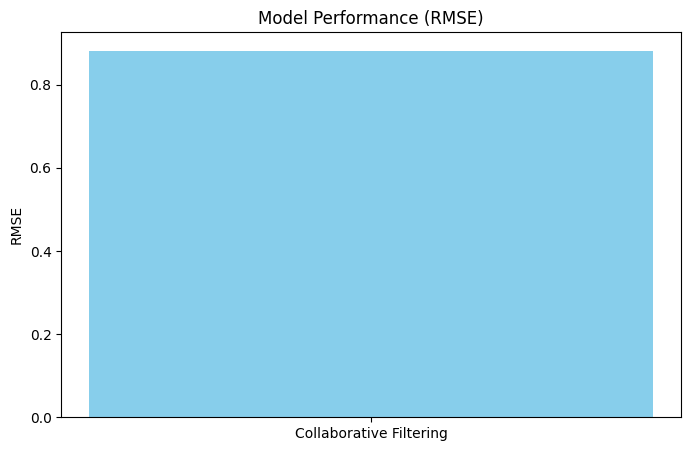

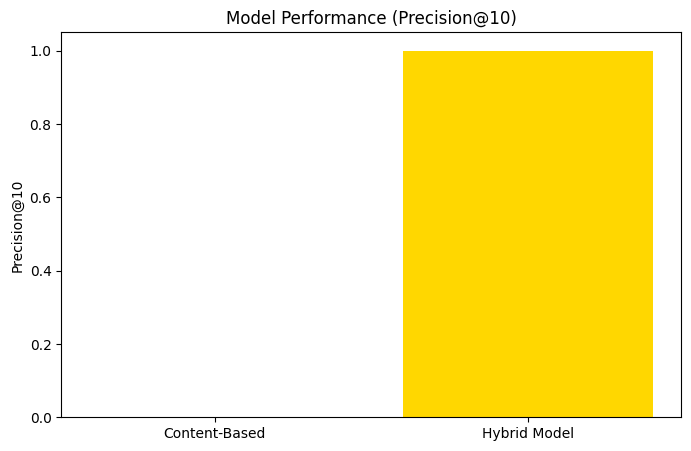

In [24]:
import matplotlib.pyplot as plt

# Example metrics (replace with actual values)
metrics = {
    'Collaborative Filtering (RMSE)': 0.8818,  # Replace with your RMSE result
    'Content-Based Filtering (Precision@10)': 0.0,  # Replace with earlier precision
    'Hybrid Model (Precision@10)': precision_hybrid  # Replace with the calculated value
}

# Separate RMSE and Precision values
rmse_values = [metrics['Collaborative Filtering (RMSE)']]
precision_values = [
    metrics['Content-Based Filtering (Precision@10)'],
    metrics['Hybrid Model (Precision@10)']
]

# Plot RMSE
plt.figure(figsize=(8, 5))
plt.bar(['Collaborative Filtering'], rmse_values, color='skyblue')
plt.title('Model Performance (RMSE)')
plt.ylabel('RMSE')
plt.show()

# Plot Precision@K
plt.figure(figsize=(8, 5))
plt.bar(['Content-Based', 'Hybrid Model'], precision_values, color=['lightgreen', 'gold'])
plt.title('Model Performance (Precision@10)')
plt.ylabel('Precision@10')
plt.show()
